In [1]:
import mdtraj as md
import numpy as np
from pymol import cmd
from pymol import stored
import matplotlib.pyplot as plt
import itertools
import warnings
import multiprocessing
from tqdm import tqdm
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import glob

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [3]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from regression_enrichment_surface import regression_enrichment_surface as rds

## Preprocessing

In [4]:
def save_pocket(pdb, sdf, name):
    cmd.reinitialize()
    cmd.load(pdb)
    cmd.load(sdf, "LIG")
    cmd.select("POCK","br. LIG around 8")
    stored.idx = 0
    cmd.iterate("POCK and n. CA", expression="stored.idx+=1")
    cmd.save(name, "POCK")
    print(stored.idx)
    return stored.idx

element_charge = {"H": +1, "I":-1,
           "N": -3,
           "P":-3,
           "C": +4,
           "O":-2,
           "F": -1,
           "S": -2,
           "Li": +1,
           "Cl": -1,
           "Br": -1}
element_radius = {"H": 1.20, "I": 1.98,
           "N": 1.55 ,
           "P":1.95,
           "C": 1.70,
           "O":1.52,
           "F": 1.47,
           "S":1.80,
           "Li": 1.82,
           "Cl": 1.75,
           "Br": 1.85}
aa_hscale = {
"ALA":  0.620,
"ARG": -2.530,
"ASN": -0.780,
"ASP": -0.900,
"CYS":  0.290,
"GLN": -0.850,
"GLU": -0.740,
"GLY":  0.480,
"HIS": -0.400,
"ILE":  1.380,
"LEU":  1.060,
"LYS": -1.500,
"MET":  0.640,
"PHE":  1.190,
"PRO":  0.120,
"SER": -0.180,
"THR": -0.050,
"TRP":  0.810,
"TYR":  0.260,
"VAL":  1.080}


def get_coulomb(i,j,z_i,z_j,r):
    if i==j:
        return 0.5*z_i**2.4
    else:
        return z_i*z_j/r

def get_e_map(t,sdf_state, pqr, grid, d_matrix):
    pocket = list(t.topology.residues)
    indices =  [int(str(residue)[3:]) for residue in t.topology.residues]
    # open the pqr and iterate through lines
    pqr = open(pqr)
    lines = pqr.readlines()
    data = []

    # discard lines that do not have the residue number
    for l in lines:
        split = l.split(' ')
        split = list(filter(lambda x: x != '', split))
        if split[0] == 'TER':
            break
        res = split[4]
        if int(res) in indices:
            # collect all x,y,charge, radius values
            data.append([float(split[5]), float(split[6]), float(split[8]), float(split[9])])
    data = np.asarray(data)

    # initialize 2D array
    e_map = np.zeros([grid,grid])
    
    for i in range(e_map.shape[0]):
        x_cell = (np.max(data[:,0]) - np.min(data[:,0]))/grid
        y_cell = (np.max(data[:,1]) - np.min(data[:,1]))/grid
        x_min = np.min(data[:,0])
        y_min = np.min(data[:,1])
        x_axis = [x_min+x_cell*i for i in range(grid)]
        y_axis = [y_min+y_cell*j for j in range(grid)]

        # place (x,y) from file into appropriate grid point
        for val in range(data.shape[0]):
            d = data[val]
            x_value = d[0]
            y_value=d[1]
            charge = d[2]
            radius = d[3]

            # naive "box" charge instead of point charge
            # also assuming constant charge rather than 1/r^2 drop off
            i_min = (int)(np.floor((x_value-x_min-radius)/x_cell))
            i_max = (int)(np.floor((x_value-x_min+radius)/x_cell))
            j_min = (int)(np.floor((y_value-y_min-radius)/y_cell))
            j_max = (int)(np.floor((y_value-y_min+radius)/y_cell))

            if i_min <0:
                i_min=0
            if j_min <0:
                j_min=0
            if i_max>=grid:
                i_max=grid-1
            if j_max>=grid:
                j_max=grid-1

            if i_min>i_max:
                print("smoething went wrot=ng")
                break
            if j_min>j_max:
                print("something went wrong")

            e_map[i_min:i_max,j_min:j_max] += charge
        
    # for each atom in the ligand add in ionic charge according to ionic radius
    lines = sdf_state.split('\n')
    lig = find_end(lines[4:])
    lig = list(filter(lambda x: 'H' not in x, lig))
    l_map = np.zeros([grid,grid])

    for l in lig:
        split = l.split(' ')
        split = list(filter(lambda x: x != '', split))
        x_value = (float)(split[0])
        y_value=(float)(split[1])
        atom = split[3]
        charge = element_charge[atom]
        radius = element_radius[atom]

        # naive "box" charge instead of point charge
        # also assuming constant charge rather than 1/r^2 drop off
        i_min = (int)(np.floor((x_value-x_min-radius)/x_cell))
        i_max = (int)(np.floor((x_value-x_min+radius)/x_cell))
        j_min = (int)(np.floor((y_value-y_min-radius)/y_cell))
        j_max = (int)(np.floor((y_value-y_min+radius)/y_cell))

        if i_min <0:
            i_min=0
        if j_min <0:
            j_min=0
        if i_max>=grid:
            i_max=grid-1
        if j_max>=grid:
            j_max=grid-1

        if i_min>i_max:
            print("smoething went wrot=ng")
            break
        if j_min>j_max:
            print("something went wrong")

        l_map[i_min:i_max,j_min:j_max] += charge
  
    return e_map, l_map

In [6]:
"""Main module."""
import matplotlib.pyplot as plt
import numpy as np
def erf(x_pred, x_true, r, y, indexs_pred, indexs_true):
    return len(
        set(indexs_pred[:int(r * indexs_pred.shape[0])]).intersection(set(indexs_true[:int(y * indexs_pred.shape[0])])))
def erfmax(x_pred, x_true, r, y, indexs_pred, indexs_true):
    return (int(min(r, y) * indexs_pred.shape[0]))
def nefr(*i):
    return erf(*i) / erfmax(*i)
def nefrcurve(points_, p, t, min_sample=-3, reverse_sort=False):
    xs = np.logspace(min_sample, 0, points_, base=10)
    ys = np.logspace(min_sample, 0, points_, base=10)
    indexs_pred = np.argsort(p)
    indexs_true = np.argsort(t)
    if reverse_sort:
        indexs_pred = indexs_pred[::-1]
        indexs_true = indexs_true[::-1]
    xx, yy = np.meshgrid(xs, ys)
    zz = np.zeros(xx.shape)
    for i in range(points_):
        for j in range(points_):
            zz[i, j] = nefr(p, t, xx[i, j], yy[i, j], indexs_pred, indexs_true)
    return xx, yy, zz
class RegressionEnrichmentSurface:
    """
    This is a conceptual class representation of a simple BLE device (GATT Server). It is essentially an extended combination of the :class:`bluepy.btle.Peripheral` and :class:`bluepy.btle.ScanEntry` classes
        :param percent_min: sets the axis bounds. Must be reasonable for your data size (i.e. cannot be data size 100 if you set -3)
        :type client: int
    """
    def __init__(self, percent_min=-3):
        self.min = percent_min
        self.nefr = None
        self.stratify = False
    def compute(self, trues, preds, stratify=None, samples=30):
        self.stratify = stratify is not None
        if not self.stratify:
            self.nefr = nefrcurve(samples, preds, trues, self.min)
        else:
            x, y, z = [], [], []
            u, indices = np.unique(stratify, return_inverse=True)
            for i in (range(u.shape[0])):
                locs = np.argwhere(indices == i).flatten()
                preds_strat = preds[locs]
                trues_strat = trues[locs]
                try:
                    x_2, y_2, z_2 = nefrcurve(30, preds_strat, trues_strat)
                except ZeroDivisionError:
                    continue
                x.append(x_2)
                y.append(y_2)
                z.append(z_2)
            self.nefr = (x, y, z)
        return self.nefr
    def plot(self, save_file=None, levels=10, title="RDS", cmap='Blues', figsize=(8, 5)):
        """Returns a list of :class:`bluepy.blte.Service` objects representing the services offered by the device. This will perform Bluetooth service discovery if this has not already been done; otherwise it will return a cached list of services immediately..
                :param save_file: if None uses plt show otherwise saves png to file
                :param levels: used for contour
                :param title: sets plot title
                :param cmap: uses matplotlib color maps
                :param figsize: sets figure size
                """
        plt.figure(figsize=figsize)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Screen top x%")
        plt.ylabel("True top x%")
        plt.contourf(np.stack(self.nefr[0]).mean(0) if self.stratify else self.nefr[0],
                     np.stack(self.nefr[1]).mean(0) if self.stratify else self.nefr[1],
                     np.stack(self.nefr[2]).mean(0) if self.stratify else self.nefr[2],
                     vmin=0,
                     vmax=1,
                     cmap=cmap,
                     levels=levels)
        plt.colorbar()
        plt.title(title)
        if save_file is None:
            plt.show()
        else:
            plt.savefig(save_file, bbox_inches='tight', dpi=300)

In [112]:
def r2_keras(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [102]:
# convert files into list of strings
# for the protein pdb and ligand sdf 
# (states are separated by $$$$)
def stringify(sdf, pdb, num_states):
    sdf_split = []
    with open(sdf,'r') as f:
        for key,group in itertools.groupby(f,lambda line: line.startswith('$$$$')):
          if not key:
            sdf_split.append("".join(list(group)))
          if len(sdf_split) == num_states:
            break
        
    #sdf_split = sdf_split[-num_states:]
    with open(pdb,'r') as f:
        pdb_string = f.readlines()       
    return sdf_split, "".join(pdb_string)

def find_end(lines):
    filtered_lines=[]
    for l in lines:
        split = l.split(' ')
        split = list(filter(lambda x: x != '', split))
        vals1 = (split[0])
        
        # stop when we get to the integers in the sdf
        if vals1.isdigit():
            return filtered_lines
        filtered_lines.append(l)
            
def create_pdb(sdf, pdb_string,i):
    lines = sdf.split('\n')
    #num_lines = (int)(lines[3].split(' ')[1])
    
    #lig = lines[4:4+num_lines-1]
    lig = find_end(lines[4:])
    lig = list(filter(lambda x: 'H' not in x, lig))
    lig_pdb = list(map(create_line, lig, np.arange(1,len(lig)+1)))
    f =  open("tmp{0}.pdb".format(i), 'w+')
    f.write("\n".join(lig_pdb))
    f.write("\n")
    f.write(pdb_string)
    f.close()

# Create one line in the new pdb file for one state
# and the protein
# Use the standardized pdb regex to create the correct string
def create_line(line,i):
    split = line.split(' ')
    split = list(filter(lambda x: x != '', split))
    vals1 = (float)(split[0])
    vals2 = (float)(split[1])
    vals3= (float)(split[2]) 
    atom = split[3]

    # workaround to get the atoms in the ligand to be residues in mdtraj reader
    if i >=10 :
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"U"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    else:
        new_string = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}".format("HETATM",i,atom,'',"UN"+str(i),'',0,'',vals1, vals2,vals3,0,0,atom,'')
    return new_string

# Create the data for ML model

# First array is contact matrix
# - ----------------| ligand atoms | protein residues
# - ligand atoms    |              | 
# ------------------|--------------|-----------------
# - protein residues|              |
#
# Second array is a mask for which cells correspond to ligand x ligand (-1), 
# protein x protein (1) and ligand x protein (0)
#
# Arrays are interpolated to 64x64
size=80
def maker_w_strings(data):
    i,sdf_state, num_residues, pdb = data
    tmp_file = str(id(multiprocessing.current_process()))
    create_pdb(sdf_state,pdb,tmp_file) # create the pdb for one states
    
    # Load the file into mdtraj
    t = md.load("tmp{0}.pdb".format(tmp_file))
    pl = len(list(t.topology.residues))
    resi = np.arange(pl)
    pairs = list(itertools.product(resi, resi))
    
    # compute conaccts
    matrix, l = md.compute_contacts(t, contacts=pairs)
    
    matrix = np.array(matrix).reshape((pl,pl))

    
            
    ### generate protein-ligand mask
    mask = np.zeros((pl,pl))
    for i in range(pl-num_residues):
        for j in range(pl-num_residues):
            # ligand
            mask[i,j] = -1
            
    for i in range(pl - num_residues,pl):
        for j in range( pl - num_residues,pl):
            # protein
            mask[i,j] = 1
            
    
    p_img = cv2.resize(matrix, dsize=(size, size), interpolation=cv2.INTER_NEAREST).reshape(size,size,1)
    m_img = cv2.resize(mask, dsize=(size, size), interpolation=cv2.INTER_NEAREST).reshape(size,size,1)
    
#     p_img = np.expand_dims(matrix, axis=-1)
#     m_img = np.expand_dims(matrix, axis=-1)
    
    p_contact_matrix = np.concatenate([p_img, m_img], axis=-1)
    os.remove("tmp{0}.pdb".format(tmp_file))
    return p_contact_matrix
    

## JAK2


In [103]:
maps_jak2=[]
num_residues = save_pocket("results/5aep.pdb", "results/results_small.sdf", "results/pocket.pdb")
print("done creating pocket")
s, pdb_string = stringify("results/results.sdf", "results/pocket.pdb", 50223)
pdb_string = [pdb_string for x in range(len(s))]

with multiprocessing.Pool(32) as p:
    num_states = len(s)
    data = list(zip(range(num_states), s, num_residues*np.ones(num_states,dtype=int), pdb_string))
    itern = p.imap(maker_w_strings, data)
    for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
        maps_jak2.append(p_contact_matrix)
p.close()
p.join()

54
done creating pocket


100%|██████████| 50223/50223 [09:39<00:00, 86.68it/s] 


In [104]:
# num_residues = save_pocket("results/5aep.pdb", "results/results_small.sdf", "results/pocket_test.pdb")
# print("done creating pocket")    
# sdf_str, pdb_str = stringify("results/results_small.sdf", "results/pocket_test.pdb", 1)
# create_pdb(sdf_str[0],"",0)
# t = md.load("tmp0.pdb")
# for i in t.topology.atoms:
#     print(i)
# pl = len(list(t.topology.atoms))
# resi = np.arange(pl)
# pairs = list(itertools.product(resi, resi))
# # compute constacts
# matrix= md.compute_distances(t, atom_pairs=pairs)
# matrix = np.array(matrix).reshape((pl,pl))
# plt.imshow(matrix)
# plt.colorbar()
# print(matrix[0][1])
# print('x: %s\ty: %s\tz: %s' % tuple(t.xyz[0, 0,:]))


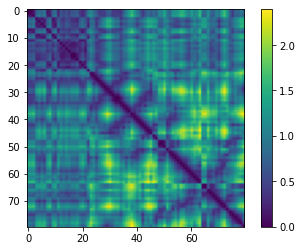

In [124]:
plt.imshow(maps_jak2[0][:,:,0])
plt.colorbar()

In [106]:
print(np.max(maps_jak2[2][:,:,0]))

2.392876625061035


In [107]:
images_jak2 = np.stack(maps_jak2,axis=0)
print(images_jak2.shape)

(50223, 80, 80, 2)


In [108]:
df_jak2 = pd.read_csv("results.csv")
docks = df_jak2["HYBRID Chemgauss4 score"].values
pickle.dump((images_jak2,docks),open("dset_jak2_8a_80x80_NEAREST.pkl","wb"),protocol=4)

In [109]:
docks = np.abs(docks)
scaler = MinMaxScaler()
docks = scaler.fit_transform(docks.reshape(-1,1))

(array([1.0000e+00, 2.0000e+00, 2.1000e+01, 1.1520e+03, 1.0890e+04,
        2.2719e+04, 1.2669e+04, 2.5040e+03, 2.4700e+02, 1.8000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

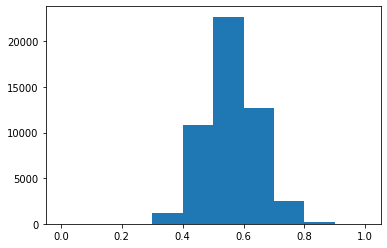

In [110]:
plt.hist(docks)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_jak2, docks, train_size=0.8,
                                                         shuffle=True)        

# model stuff
dr = 0.3

model = Sequential()
model.add(Conv2D(3, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=(size,size,2)))
model.add(Conv2D(32, (4,4), activation='relu'))
model.add(BatchNormalization(axis=-1))
#model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))

model.add(Conv2D(32, (4,4), activation='relu'))
model.add(Conv2D(32, (4,4), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))

model.add(Conv2D(32, (4,4), activation='relu'))
model.add(Conv2D(32, (4,4), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))

model.add(Flatten())

model.add(Dropout(dr))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
print(model.summary())
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['mean_squared_error', r2_keras])
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

# Plot training & validation loss values
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('jak2 r2 train_size')
plt.ylabel('r2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('jak2 loss')
plt.ylabel('mse')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

print("r2", r2_score(y_test_inv, y_pred_inv))
print("pearson", pearsonr(y_test_inv.flatten(),y_pred_inv.flatten()))
print("spearman", spearmanr(y_test_inv.flatten(),y_pred_inv.flatten()))
print("MSE actual", mean_squared_error(y_test_inv, y_pred_inv))

plt.hist(y_test_inv, alpha=0.5, label="test")
plt.hist(y_pred_inv,alpha=0.5, label="pred")
plt.legend()
plt.show()
plt.clf()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 79, 79, 3)         27        
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 76, 76, 32)        1568      
_________________________________________________________________
batch_normalization_34 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
dropout_45 (Dropout)         (None, 76, 76, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 73, 73, 32)        16416     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 70, 70, 32)        16416     
_________________________________________________________________
batch_normalization_35 (Batc (None, 70, 70, 32)      

40178/40178 [==============================] - 12s 296us/sample - loss: 0.0053 - mean_squared_error: 0.0053 - r2_keras: 0.2409 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_r2_keras: 0.2721
Epoch 27/50
40178/40178 [==============================] - 12s 297us/sample - loss: 0.0051 - mean_squared_error: 0.0051 - r2_keras: 0.2638 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_r2_keras: 0.2900
Epoch 28/50
40178/40178 [==============================] - 12s 298us/sample - loss: 0.0050 - mean_squared_error: 0.0050 - r2_keras: 0.2813 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_r2_keras: 0.3434
Epoch 29/50
40178/40178 [==============================] - 12s 299us/sample - loss: 0.0048 - mean_squared_error: 0.0048 - r2_keras: 0.3053 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_r2_keras: 0.3287
Epoch 30/50
40178/40178 [==============================] - 12s 299us/sample - loss: 0.0047 - mean_squared_error: 0.0047 - r2_keras: 0.3205 - val_loss: 0.004

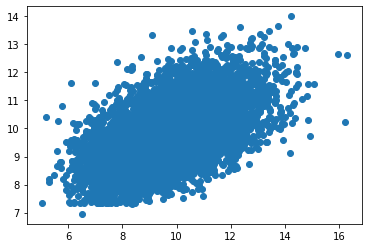

In [51]:
plt.scatter(y_test_inv, y_pred_inv)

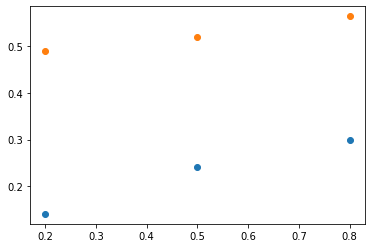

In [52]:
plt.scatter(train_size, r2_list)
plt.scatter(train_size, [p[0] for p in pearson_list])
#plt.scatter(train_size, loss)

In [54]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 59, 59, 3)         219       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 57, 57, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 32)       

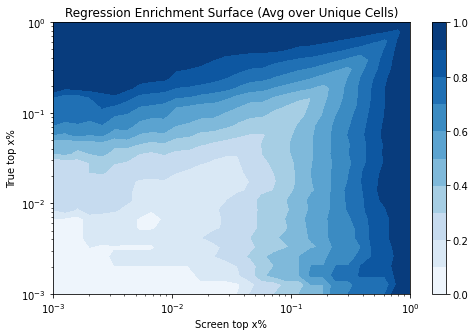

In [53]:
rds_model = rds.RegressionEnrichmentSurface(percent_min=-3)
rds_model.compute(y_test_inv.flatten(), y_pred_inv.flatten(), samples=30)
rds_model.plot(save_file="rds_on_cell.png",
                   title='Regression Enrichment Surface (Avg over Unique Cells)')

## ADRP

In [12]:
maps=[]
num_residues = save_pocket("april27/ADRP/ADRP_6W02_A_1_H.pdb", "april27/ADRP/adrp_adpr_A_cat_sorted_top100.sdf", "april27/ADRP/adrp_gen_pock.pdb")
print("done creating pocket")
s, pdb_string = stringify("april27/ADRP/adrp_adpr_A_cat_sorted.sdf", "april27/ADRP/adrp_gen_pock.pdb", 50000)
pdb_string = [pdb_string for x in range(len(s))]

with multiprocessing.Pool(32) as p:
    num_states = len(s)
    data = list(zip(range(num_states), s, num_residues*np.ones(num_states,dtype=int), pdb_string))
    itern = p.imap(maker_w_strings, data)
    for i,p_contact_matrix in enumerate(tqdm(itern, total=num_states)):
        maps.append(p_contact_matrix)
p.close()
p.join()

done creating pocket


100%|██████████| 50000/50000 [04:17<00:00, 194.28it/s]


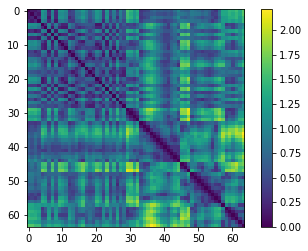

In [13]:
plt.imshow(maps[0][:,:,0])
plt.colorbar()

In [14]:
images_adrp = np.stack(maps,axis=0)
print(images_adrp.shape)

(50000, 64, 64, 2)


In [13]:
#df_adrp = pd.read_csv("rescore_top10k.csv")
df_adrp = pd.read_csv("april27/ADRP/adrp_adpr_A_cat_sorted.csv").iloc[0:50000]
docks = df_adrp["Chemgauss4"].values
#pickle.dump((images_adrp,docks),open("dset_adrp.pkl","wb"))
scaler = MinMaxScaler()
docks = scaler.fit_transform(docks.reshape(-1,1))

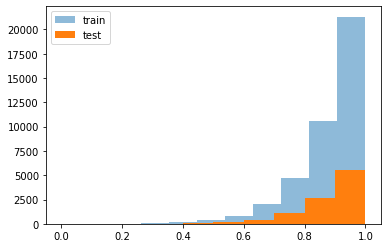

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 59, 59, 3)         219       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 3)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 29, 29, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)       

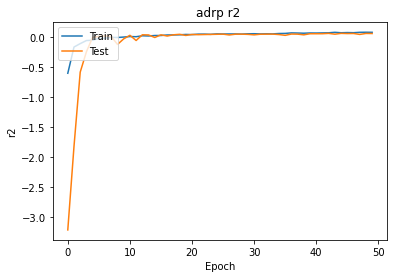

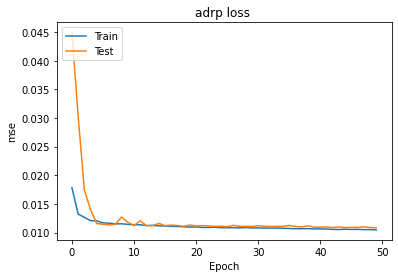

r2 0.08429866914323425
pearson (0.29486190858545325, 9.110805845869483e-200)
spearman SpearmanrResult(correlation=0.1908275091321648, pvalue=1.2193891789399112e-82)
MSE actual 0.34280355420719816


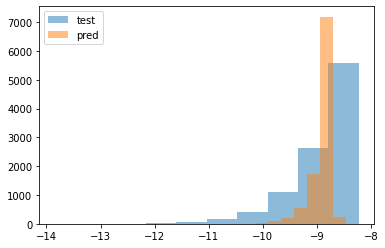

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images_adrp, docks, test_size=0.2,
                                                         shuffle=True)        

# plot train/test split
plt.hist(y_train, alpha=0.5, label='train')
plt.hist(y_test,alpha=1, label='test')
plt.legend()
plt.show()

# model stuff
dr = 0.1


model = Sequential()
model.add(Conv2D(3, kernel_size=(6, 6),
                 activation='relu',
                 input_shape=(64,64,2)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(dr))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(dr))

# model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(dr))

model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(dr))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['mean_squared_error', r2_keras])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test))

# Plot training & validation loss values
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('adrp r2 ')
plt.ylabel('r2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('adrp loss ')
plt.ylabel('mse')

plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

print("r2", r2_score(y_test_inv, y_pred_inv))
print("pearson", pearsonr(y_test_inv.flatten(),y_pred_inv.flatten()))
print("spearman", spearmanr(y_test_inv.flatten(),y_pred_inv.flatten()))
print("MSE actual", mean_squared_error(y_test_inv, y_pred_inv))

plt.hist(y_test_inv, alpha=0.5, label="test")
plt.hist(y_pred_inv,alpha=0.5, label="pred")
plt.legend()
plt.show()

## Multi-protein

In [8]:
data_images =[]
data_scores = []
data_images_bottom =[]
data_scores_bottom = []
files_m = glob.glob('./**/*high.matrices.npy', recursive=True)
files_s = glob.glob('./**/*.scores', recursive=True)
for m,s in zip(files_m, files_s):
    print(m,s)
#     if "bottom" not in m:
    data_images.append(np.load(m)[0:5000])
    data_scores.append(pd.read_csv(s).iloc[0:5000])
#     else:
#     data_images_bottom.append(np.load(m)[-5000:])
#     data_scores_bottom.append(pd.read_csv(s).iloc[-5000:])
    

./april27/PLPro/2/plpro_2.high.matrices.npy ./april27/PLPro/2/plpro_2.scores
./april27/PLPro/1/plpro_1.high.matrices.npy ./april27/PLPro/1/plpro_1.scores
./april27/NSP15_6w01/2/NSP15_2_6w01.high.matrices.npy ./april27/NSP15_6w01/2/NSP15_2_6w01.scores
./april27/NSP15_6w01/1/NSP15_1_6w01.high.matrices.npy ./april27/NSP15_6w01/1/NSP15_1_6w01.scores
./april27/NSP15_6vww/1/NSP15_1_6vww.high.matrices.npy ./april27/NSP15_6vww/1/NSP15_1_6vww.scores
./april27/NSP15_6vww/2/NSP15_2_6vww.high.matrices.npy ./april27/NSP15_6vww/2/NSP15_2_6vww.scores
./april27/3CLPro/1/3CLPro_1.high.matrices.npy ./april27/3CLPro/1/3CLPro_1.scores
./april27/3CLPro/2/3CLPro_2.high.matrices.npy ./april27/3CLPro/2/3CLPro_2.scores
./april27/3CLPro/3/3CLPro_3.high.matrices.npy ./april27/3CLPro/3/3CLPro_3.scores
./april27/ADRP/ADRP_6W02_A_1_H.high.matrices.npy ./april27/ADRP/ADRP_6W02_A_1_H.scores
./april27/DNMT3A/DNMT3A_chainA.high.matrices.npy ./april27/DNMT3A/DNMT3A_chainA.scores
./april27/NSUN2/NSUN2_model.high.matrices

In [9]:
X = np.vstack(data_images)
y = pd.concat(data_scores)

Text(0.5, -0.1, 'test')

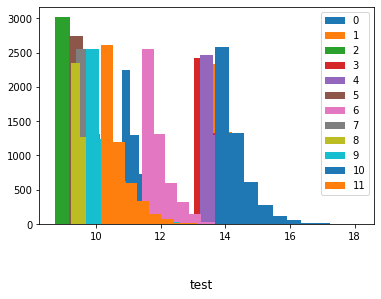

In [10]:
for i in range(12):
    plt.hist(-1*y['Chemgauss4'].iloc[5000*i:5000*(i+1)], label=i)
plt.legend()    
plt.figtext(0.5, -0.1,
                "test", ha="center", fontsize=12)


(60000, 64, 64, 2)


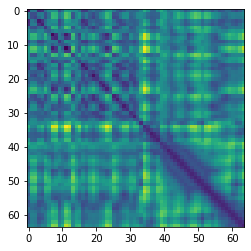

In [11]:
X_2d = X[:,:,:,0:2]
print(X_2d.shape)
plt.imshow(X_2d[0][:,:,0])

# X_2d_bottom = X_bottom[:,:,:,0:2]
# print(X_2d_bottom.shape)

Chemgauss4


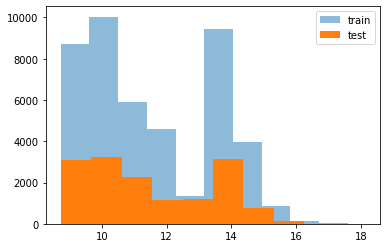

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 63, 63, 3)         27        
_________________________________________________________________
flatten_7 (Flatten)          (None, 11907)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 11907)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                762112    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 762,204
Trainable params: 762,204
Non-trainable params: 0
_________________________________________________________________
None
Train on 45000 samples, validate on 15000 samples
Epoch 1/50
45000/45000 [==============================] - 5

Epoch 35/50
45000/45000 [==============================] - 4s 87us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - r2_keras: 0.9206 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_r2_keras: 0.9300
Epoch 36/50
45000/45000 [==============================] - 4s 88us/sample - loss: 0.0032 - mean_squared_error: 0.0032 - r2_keras: 0.9215 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_r2_keras: 0.9312
Epoch 37/50
45000/45000 [==============================] - 4s 85us/sample - loss: 0.0031 - mean_squared_error: 0.0031 - r2_keras: 0.9220 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_r2_keras: 0.9289
Epoch 38/50
45000/45000 [==============================] - 4s 85us/sample - loss: 0.0031 - mean_squared_error: 0.0031 - r2_keras: 0.9217 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_r2_keras: 0.9310
Epoch 39/50
45000/45000 [==============================] - 4s 83us/sample - loss: 0.0031 - mean_squared_error: 0.0031 - r2_keras: 0.9225 - val_loss: 0.0

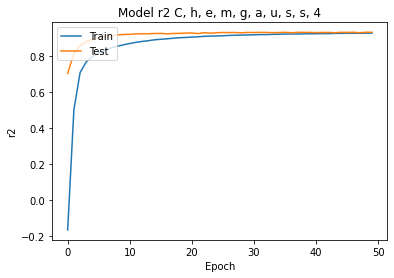

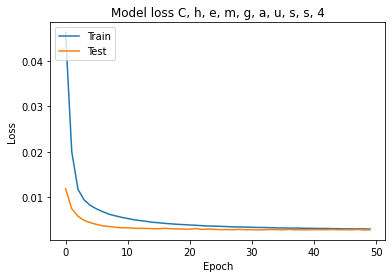

r2 0.9325494659214879
pearson (0.9658584058005424, 0.0)
spearman SpearmanrResult(correlation=0.9372587094397805, pvalue=0.0)
MSE actual 0.24274051538732389


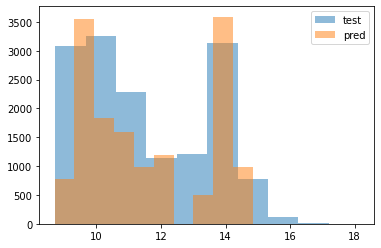

In [21]:
# X_adrp = images_adrp[:,:,:,2:4]
# y=df_adrp
columns = [ 'CG3:Steric', 'CG3:Clash', 'CG3:ProDesolv', 'CG3:LigDesolv',
       'CG3:LigDesolvHB', 'CG4:HB', 'Chemgauss4']
subsets = [ ['CG3:Steric', 'CG3:Clash', 'CG4:HB'], ['CG3:ProDesolv', 'CG3:LigDesolv',
       'CG3:LigDesolvHB'], ['Chemgauss4']]
total = ['Chemgauss4']
for c in total:
    print(c)
    isList = isinstance(c,list)
    df_new = y.copy(deep=True)
    scaler = MinMaxScaler()
    dock_score = np.abs(df_new[c].to_numpy())
    if isList:
        dock_score = scaler.fit_transform(np.sum(dock_score,axis=-1).reshape(-1,1))
    else:
        dock_score = scaler.fit_transform(dock_score.reshape(-1,1))
    df_new['score'] = dock_score    
    
    X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_2d, df_new, test_size=0.25,
                                                         shuffle=True)        

    dock_score_train= y_train_top['score'].to_numpy()
    dock_score_test = y_test_top['score'].to_numpy()
    plt_train=scaler.inverse_transform(dock_score_train.reshape(-1,1))
    plt_test=scaler.inverse_transform(dock_score_test.reshape(-1,1))
        
    # plot train/test split
    plt.hist(plt_train, alpha=0.5, label='train')
    plt.hist(plt_test,alpha=1, label='test')
    plt.legend()
    plt.show()
    
    # model stuff
    dr = 0.1
    model = Sequential()
    model.add(Conv2D(3, kernel_size=(2, 2),
                     activation='relu',
                     input_shape=(64,64,2)))
 #   model.add(Conv2D(32, (3, 3), activation='relu'))
 #   model.add(Conv2D(32, (3, 3), activation='relu'))
#    model.add(MaxPooling2D(pool_size=(2,2)))
#    model.add(Dropout(dr))
    model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
    model.add(Dropout(dr))
    model.add(Dense(64, activation='relu'))
   # model.add(Dropout(dr))
    model.add(Dense(1))

    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                  metrics=['mean_squared_error', r2_keras])
    print(model.summary())
    history = model.fit(X_train_top, dock_score_train,
              batch_size=64,
              epochs=50,
              verbose=1,
              validation_data=(X_test_top, dock_score_test))
    
    # Plot training & validation loss values
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('Model r2 ' + ', '.join(c))
    plt.ylabel('r2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss ' + ', '.join(c))
    plt.ylabel('Loss')

    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(X_test_top)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(dock_score_test.reshape(-1,1))

    print("r2", r2_score(y_test_inv, y_pred_inv))
    print("pearson", pearsonr(y_test_inv.flatten(),y_pred_inv.flatten()))
    print("spearman", spearmanr(y_test_inv.flatten(),y_pred_inv.flatten()))
    print("MSE actual", mean_squared_error(y_test_inv, y_pred_inv))

    plt.hist(y_test_inv, alpha=0.5, label="test")
    plt.hist(y_pred_inv,alpha=0.5, label="pred")
    plt.legend()
    plt.show()

In [ ]:
print(np.max(y_pred_inv))
print(np.max(y_test_inv))

In [66]:
top_pred = y_test_top.iloc[np.argsort(y_pred_inv.flatten())[-1000:]][['SMILES']].to_numpy()
top_true = y_test_top.iloc[np.argsort(y_test_inv.flatten())[-1000:]][['SMILES']].to_numpy()

In [67]:
check = []
for i in range(top_pred.shape[0]):
    check.append(top_pred[i] in top_true)
print(np.sum(check))

357
